#🧤 HYGEIA GLOVE – AI HEALTH SYSTEM

Setup & Install

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, Dense, Dropout,
                                      BatchNormalization, Bidirectional, Input,
                                      Flatten, Concatenate, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from scipy import signal
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

print(" Advanced Medical AI System Initialized")
print(f" TensorFlow Version: {tf.__version__}")
print(f" GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


✅ Advanced Medical AI System Initialized
📊 TensorFlow Version: 2.19.0
🧠 GPU Available: False


Upload & Load Data

In [167]:
print("="*70)
print(" "*20 + "📁 DATA ACQUISITION MODULE")
print("="*70)

uploaded = files.upload()
filename = list(uploaded.keys())[0]


df_raw = pd.read_csv(io.BytesIO(uploaded[filename]), skiprows=1)


set_a = df_raw.iloc[:, [0, 1, 2]].copy()
set_a.columns = ['Temp', 'SpO2', 'Pulse']

set_b = df_raw.iloc[:, [3, 4, 5]].copy()
set_b.columns = ['Temp', 'SpO2', 'Pulse']


df = pd.concat([set_a, set_b], axis=0, ignore_index=True)

for col in ['Temp', 'SpO2', 'Pulse']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


df = df[
    (df['Temp'] > 30) & (df['Temp'] < 45) &
    (df['SpO2'] > 0) & (df['SpO2'] <= 100) &
    (df['Pulse'] > 0) & (df['Pulse'] < 200)
].reset_index(drop=True)

print(f"\n Successfully loaded {len(df)} valid health records")
print(f" Temperature range: {df['Temp'].min():.1f}°C - {df['Temp'].max():.1f}°C")
print(f" SpO2 range: {df['SpO2'].min():.0f}% - {df['SpO2'].max():.0f}%")
print(f" Pulse range: {df['Pulse'].min():.0f} - {df['Pulse'].max():.0f} BPM")
print(f" Missing values: {df.isnull().sum().sum()}")

df.head(10)


                    📁 DATA ACQUISITION MODULE


Saving Readings Report .csv to Readings Report  (4).csv

 Successfully loaded 396 valid health records
 Temperature range: 36.2°C - 38.4°C
 SpO2 range: 91% - 100%
 Pulse range: 69 - 128 BPM
 Missing values: 0


,Temp,SpO2,Pulse
0,36.8,97,100
1,37.0,97,91
2,37.1,98,90
3,37.3,98,91
4,37.3,97,91
5,36.7,97,84
6,36.6,99,91
7,37.4,97,110
8,37.1,98,102
9,38.2,96,87


Advanced Feature Engineering

In [168]:
print("="*70)
print(" "*15 + "🧬 ADVANCED FEATURE ENGINEERING")
print("="*70)


WINDOWS = [3, 5, 10]

for w in WINDOWS:
    df[f'Temp_MA_{w}'] = df['Temp'].rolling(window=w, min_periods=1).mean()
    df[f'SpO2_MA_{w}'] = df['SpO2'].rolling(window=w, min_periods=1).mean()
    df[f'Pulse_MA_{w}'] = df['Pulse'].rolling(window=w, min_periods=1).mean()


for w in [5, 10]:
    df[f'Temp_Std_{w}'] = df['Temp'].rolling(window=w, min_periods=1).std()
    df[f'SpO2_Std_{w}'] = df['SpO2'].rolling(window=w, min_periods=1).std()
    df[f'Pulse_Std_{w}'] = df['Pulse'].rolling(window=w, min_periods=1).std()


df['Temp_Delta'] = df['Temp'].diff()
df['SpO2_Delta'] = df['SpO2'].diff()
df['Pulse_Delta'] = df['Pulse'].diff()


df['Temp_Accel'] = df['Temp_Delta'].diff()
df['Pulse_Accel'] = df['Pulse_Delta'].diff()


df['Pulse_Peak'] = df['Pulse'] > df['Pulse'].rolling(window=10, min_periods=1).quantile(0.9)
df['SpO2_Drop'] = df['SpO2'] < df['SpO2'].rolling(window=10, min_periods=1).quantile(0.1)


df['Vital_Risk_Score'] = (
    (100 - df['SpO2']) * 0.5 +  # Lower oxygen = higher risk
    (df['Temp'] - 36.5) * 2 +    # Higher temp deviation = higher risk
    abs(df['Pulse'] - 75) * 0.1  # Pulse deviation from normal
)


df = df.fillna(method='bfill').fillna(method='ffill')

print(f"\n Created {len(df.columns) - 3} advanced medical features")
print(f" Total feature set: {len(df.columns)} columns")
print("\n Feature Categories:")
print(f"  • Trend indicators (Moving Averages): {sum('MA' in c for c in df.columns)}")
print(f"  • Variability measures (Std): {sum('Std' in c for c in df.columns)}")
print(f"  • Rate of change (Delta): {sum('Delta' in c for c in df.columns)}")
print(f"  • Acceleration features: {sum('Accel' in c for c in df.columns)}")
print(f"  • Clinical risk scores: {sum('Risk' in c or 'Peak' in c or 'Drop' in c for c in df.columns)}")


               🧬 ADVANCED FEATURE ENGINEERING

 Created 23 advanced medical features
 Total feature set: 26 columns

 Feature Categories:
  • Trend indicators (Moving Averages): 9
  • Variability measures (Std): 6
  • Rate of change (Delta): 3
  • Acceleration features: 2
  • Clinical risk scores: 3


Enhanced Medical Classification System

In [131]:
print("="*70)
print(" "*15 + "🏥 MEDICAL CLASSIFICATION ENGINE")
print("="*70)

def advanced_health_classification(row):
    """
    Multi-factor health classification based on clinical guidelines
    Returns: 0 (Normal), 1 (Warning), 2 (Critical)
    """


    critical_conditions = [
        row['SpO2'] < 88,                          # Severe hypoxia
        row['Temp'] > 39.0,                        # High fever
        row['Pulse'] > 130,                        # Severe tachycardia
        row['Pulse'] < 45,                         # Severe bradycardia
        row['SpO2_Std_5'] > 4,                    # Unstable oxygen
        row['Vital_Risk_Score'] > 25,             # High combined risk
        (row['SpO2'] < 92 and row['Pulse'] > 110) # Combined emergency
    ]

    if any(critical_conditions):
        return 2  # 🚨 CRITICAL

    # Warning thresholds (monitoring required)
    warning_conditions = [
        row['SpO2'] < 94,                          # Mild hypoxia
        row['Temp'] > 37.8,                        # Elevated temperature
        row['Pulse'] > 105,                        # Elevated heart rate
        row['Pulse'] < 55,                         # Low heart rate
        row['Pulse_Std_5'] > 12,                  # Irregular heartbeat
        row['SpO2_Delta'] < -2,                   # Rapid oxygen drop
        row['Vital_Risk_Score'] > 12              # Moderate risk
    ]

    if any(warning_conditions):
        return 1  # ⚠️ WARNING

    return 0  # ✅ NORMAL

# Apply classification
df['Health_Status'] = df.apply(advanced_health_classification, axis=1)
df['Condition'] = df['Health_Status'].map({0: 'Normal', 1: 'At Risk', 2: 'Critical'})

# Calculate distribution
print("\n📊 HEALTH STATUS DISTRIBUTION:")
print("="*70)
for status, label in [(0, 'Normal'), (1, 'At Risk'), (2, 'Critical')]:
    count = sum(df['Health_Status'] == status)
    percentage = (count / len(df)) * 100
    emoji = ['✅', '⚠️', '🚨'][status]
    print(f"{emoji} {label:12s}: {count:5d} cases ({percentage:5.2f}%)")

# Check class balance
class_counts = df['Health_Status'].value_counts()
if class_counts.min() / class_counts.max() < 0.1:
    print("\n⚠️  Note: Class imbalance detected. Using stratified sampling.")

               🏥 MEDICAL CLASSIFICATION ENGINE

📊 HEALTH STATUS DISTRIBUTION:
✅ Normal      :   294 cases (74.24%)
⚠️ At Risk     :   102 cases (25.76%)
🚨 Critical    :     0 cases ( 0.00%)


Visualization

               📊 GENERATING CLINICAL VISUALIZATIONS


Text(0.5, 1.0, 'Clinical Feature Correlation Matrix')

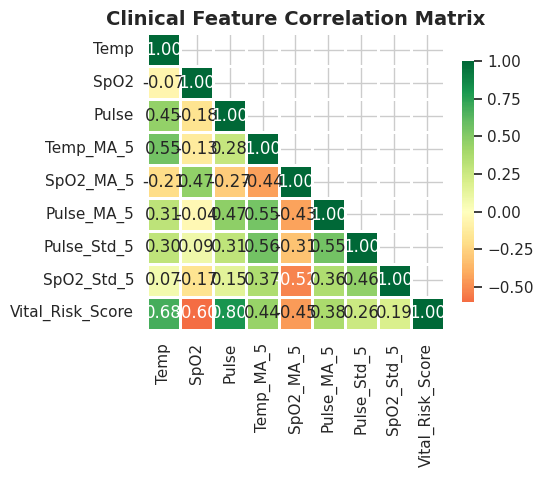

In [169]:
print("="*70)
print(" "*15 + "📊 GENERATING CLINICAL VISUALIZATIONS")
print("="*70)


fig = plt.figure(figsize=(22, 18))

# Advanced Correlation Heatmap
plt.subplot(4, 4, 1)
key_features = ['Temp', 'SpO2', 'Pulse', 'Temp_MA_5', 'SpO2_MA_5',
                'Pulse_MA_5', 'Pulse_Std_5', 'SpO2_Std_5', 'Vital_Risk_Score']
corr = df[key_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Clinical Feature Correlation Matrix', fontweight='bold', fontsize=14)




KeyError: 'Condition'

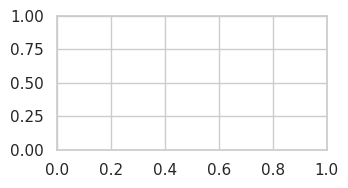

In [181]:
# Health Status Distribution (Safe Pie Chart)

plt.subplot(4, 4, 2)


labels_order = ['Normal', 'At Risk', 'Critical']
colors = ['#2ecc71', '#f39c12', '#e74c3c']

status_counts = df['Condition'].value_counts().reindex(labels_order).fillna(0)


status_counts = status_counts.astype(int)

plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

plt.title('Patient Health Distribution', fontweight='bold', fontsize=14)
plt.pie(status_counts, labels=status_counts.index, colors=colors,
        autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))




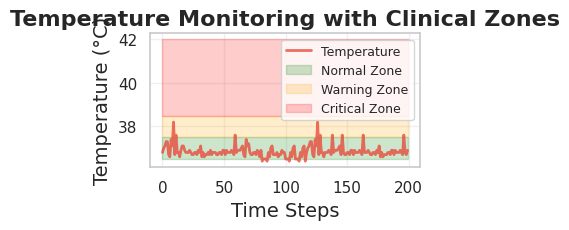

In [182]:
#  Temperature Time Series with Zones
plt.subplot(4, 4, 3)
plt.plot(df['Temp'][:200], color='#e74c3c', linewidth=2, alpha=0.8, label='Temperature')
plt.fill_between(range(200), 36.5, 37.5, alpha=0.2, color='green', label='Normal Zone')
plt.fill_between(range(200), 37.5, 38.5, alpha=0.2, color='orange', label='Warning Zone')
plt.fill_between(range(200), 38.5, 42, alpha=0.2, color='red', label='Critical Zone')
plt.title('Temperature Monitoring with Clinical Zones', fontweight='bold')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time Steps')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

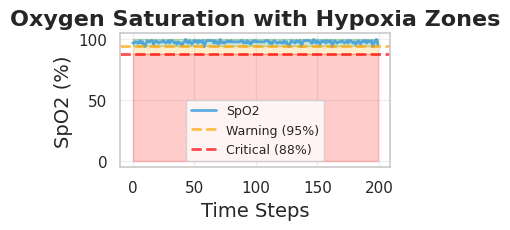

In [183]:
# SpO2 Analysis with Hypoxia Zones
plt.subplot(4, 4, 4)
plt.plot(df['SpO2'][:200], color='#3498db', linewidth=2, alpha=0.8, label='SpO2')
plt.axhline(95, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Warning (95%)')
plt.axhline(88, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Critical (88%)')
plt.fill_between(range(200), 95, 100, alpha=0.2, color='green')
plt.fill_between(range(200), 88, 95, alpha=0.2, color='orange')
plt.fill_between(range(200), 0, 88, alpha=0.2, color='red')
plt.title('Oxygen Saturation with Hypoxia Zones', fontweight='bold')
plt.ylabel('SpO2 (%)')
plt.xlabel('Time Steps')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)



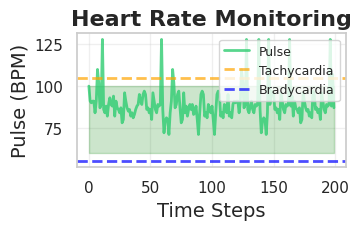

In [184]:
#  Pulse Rate Analysis
plt.subplot(4, 4, 5)
plt.plot(df['Pulse'][:200], color='#2ecc71', linewidth=2, alpha=0.8, label='Pulse')
plt.axhline(105, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Tachycardia')
plt.axhline(55, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Bradycardia')
plt.fill_between(range(200), 60, 100, alpha=0.2, color='green')
plt.title('Heart Rate Monitoring', fontweight='bold')
plt.ylabel('Pulse (BPM)')
plt.xlabel('Time Steps')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)









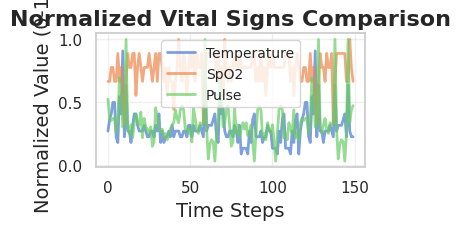

In [185]:
# Normalized Multi-Vital Comparison
plt.subplot(4, 4, 6)
sample_range = slice(0, 150)
norm_temp = (df['Temp'][sample_range] - df['Temp'].min()) / (df['Temp'].max() - df['Temp'].min())
norm_spo2 = (df['SpO2'][sample_range] - df['SpO2'].min()) / (df['SpO2'].max() - df['SpO2'].min())
norm_pulse = (df['Pulse'][sample_range] - df['Pulse'].min()) / (df['Pulse'].max() - df['Pulse'].min())
plt.plot(norm_temp, label='Temperature', alpha=0.7, linewidth=2)
plt.plot(norm_spo2, label='SpO2', alpha=0.7, linewidth=2)
plt.plot(norm_pulse, label='Pulse', alpha=0.7, linewidth=2)
plt.title('Normalized Vital Signs Comparison', fontweight='bold')
plt.ylabel('Normalized Value (0-1)')
plt.xlabel('Time Steps')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)


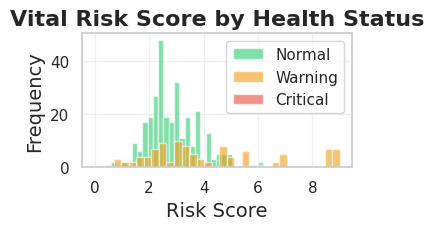

In [142]:
#  Vital Risk Score Distribution
plt.subplot(4, 4, 7)
for status in [0, 1, 2]:
    subset = df[df['Health_Status'] == status]['Vital_Risk_Score']
    plt.hist(subset, bins=30, alpha=0.6, label=['Normal', 'Warning', 'Critical'][status],
             color=colors[status])
plt.title('Vital Risk Score by Health Status', fontweight='bold')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

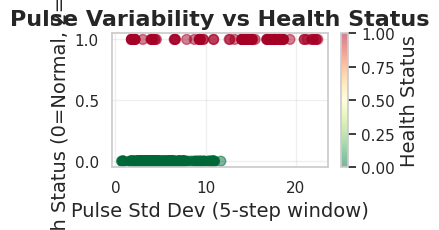

In [143]:
#  Pulse Variability vs Health Status
plt.subplot(4, 4, 8)
plt.scatter(df['Pulse_Std_5'], df['Health_Status'],
            c=df['Health_Status'], cmap='RdYlGn_r', alpha=0.5, s=50)
plt.title('Pulse Variability vs Health Status', fontweight='bold')
plt.xlabel('Pulse Std Dev (5-step window)')
plt.ylabel('Health Status (0=Normal, 2=Critical)')
plt.colorbar(label='Health Status')
plt.grid(True, alpha=0.3)



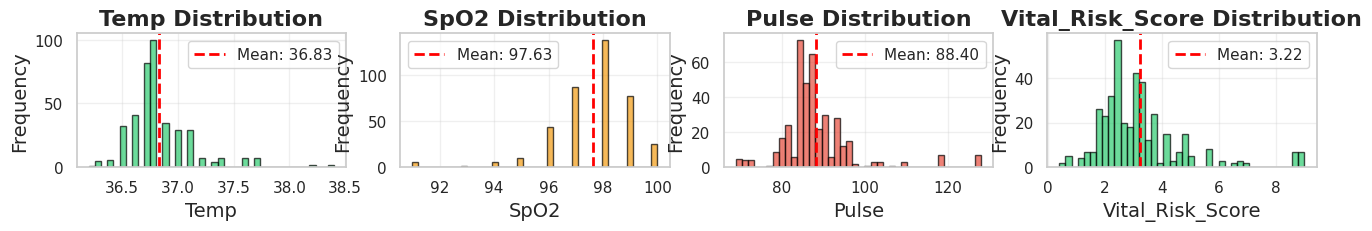

In [186]:
#  Distribution Analysis
vital_cols = ['Temp', 'SpO2', 'Pulse', 'Vital_Risk_Score']
for i, col in enumerate(vital_cols, start=9):
    plt.subplot(4, 4, i)
    df[col].hist(bins=40, color=colors[i%3], alpha=0.7, edgecolor='black')
    plt.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.2f}')
    plt.title(f'{col} Distribution', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)



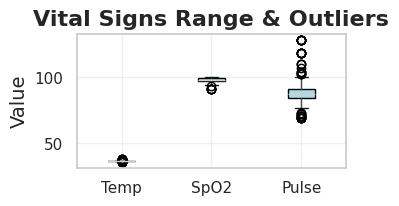

In [145]:
#  Box Plot Analysis
plt.subplot(4, 4, 13)
df[['Temp', 'SpO2', 'Pulse']].boxplot(patch_artist=True,
                                       boxprops=dict(facecolor='lightblue'))
plt.title('Vital Signs Range & Outliers', fontweight='bold')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)


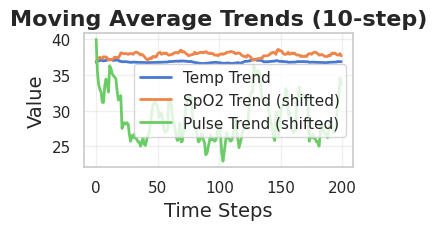

In [187]:
#  Trend Analysis
plt.subplot(4, 4, 14)
plt.plot(df['Temp_MA_10'][:200], label='Temp Trend', linewidth=2)
plt.plot(df['SpO2_MA_10'][:200] - 60, label='SpO2 Trend (shifted)', linewidth=2)
plt.plot(df['Pulse_MA_10'][:200] - 60, label='Pulse Trend (shifted)', linewidth=2)
plt.title('Moving Average Trends (10-step)', fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)


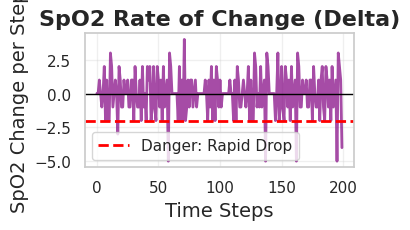

In [188]:
#  SpO2 Delta (Rate of Change)
plt.subplot(4, 4, 15)
plt.plot(df['SpO2_Delta'][:200], color='purple', linewidth=2, alpha=0.7)
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.axhline(-2, color='red', linestyle='--', linewidth=2, label='Danger: Rapid Drop')
plt.title('SpO2 Rate of Change (Delta)', fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('SpO2 Change per Step')
plt.legend()
plt.grid(True, alpha=0.3)

Additional Advanced Visualizations

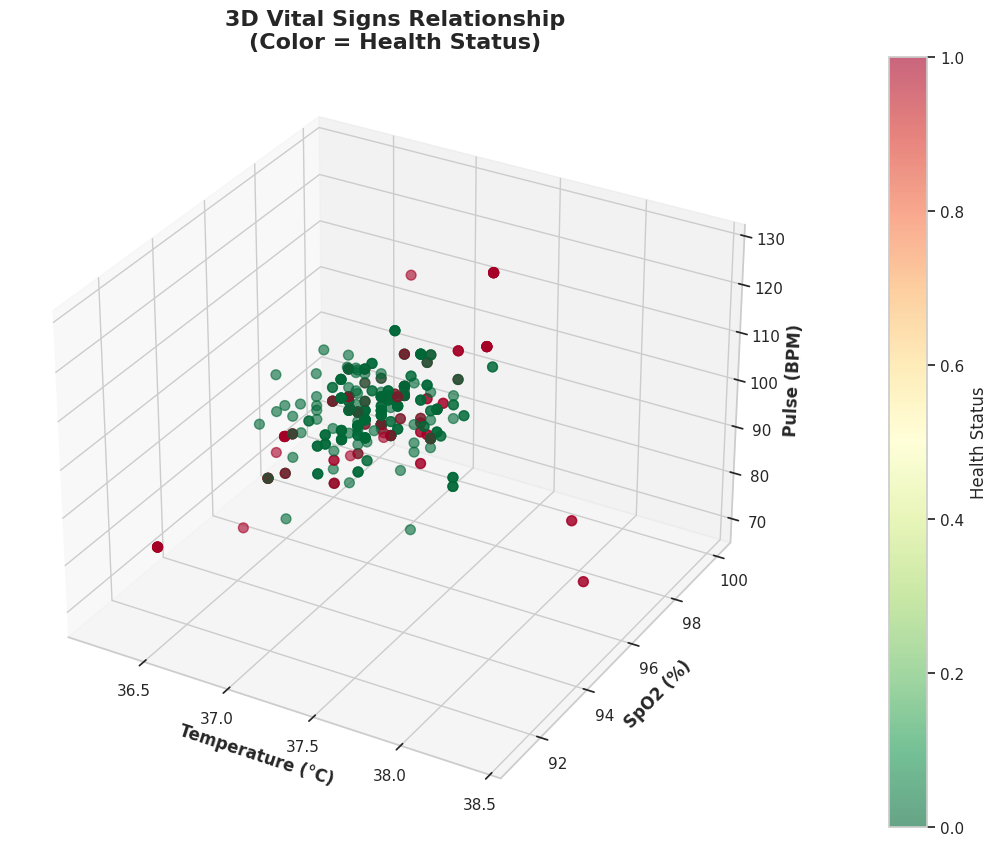

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

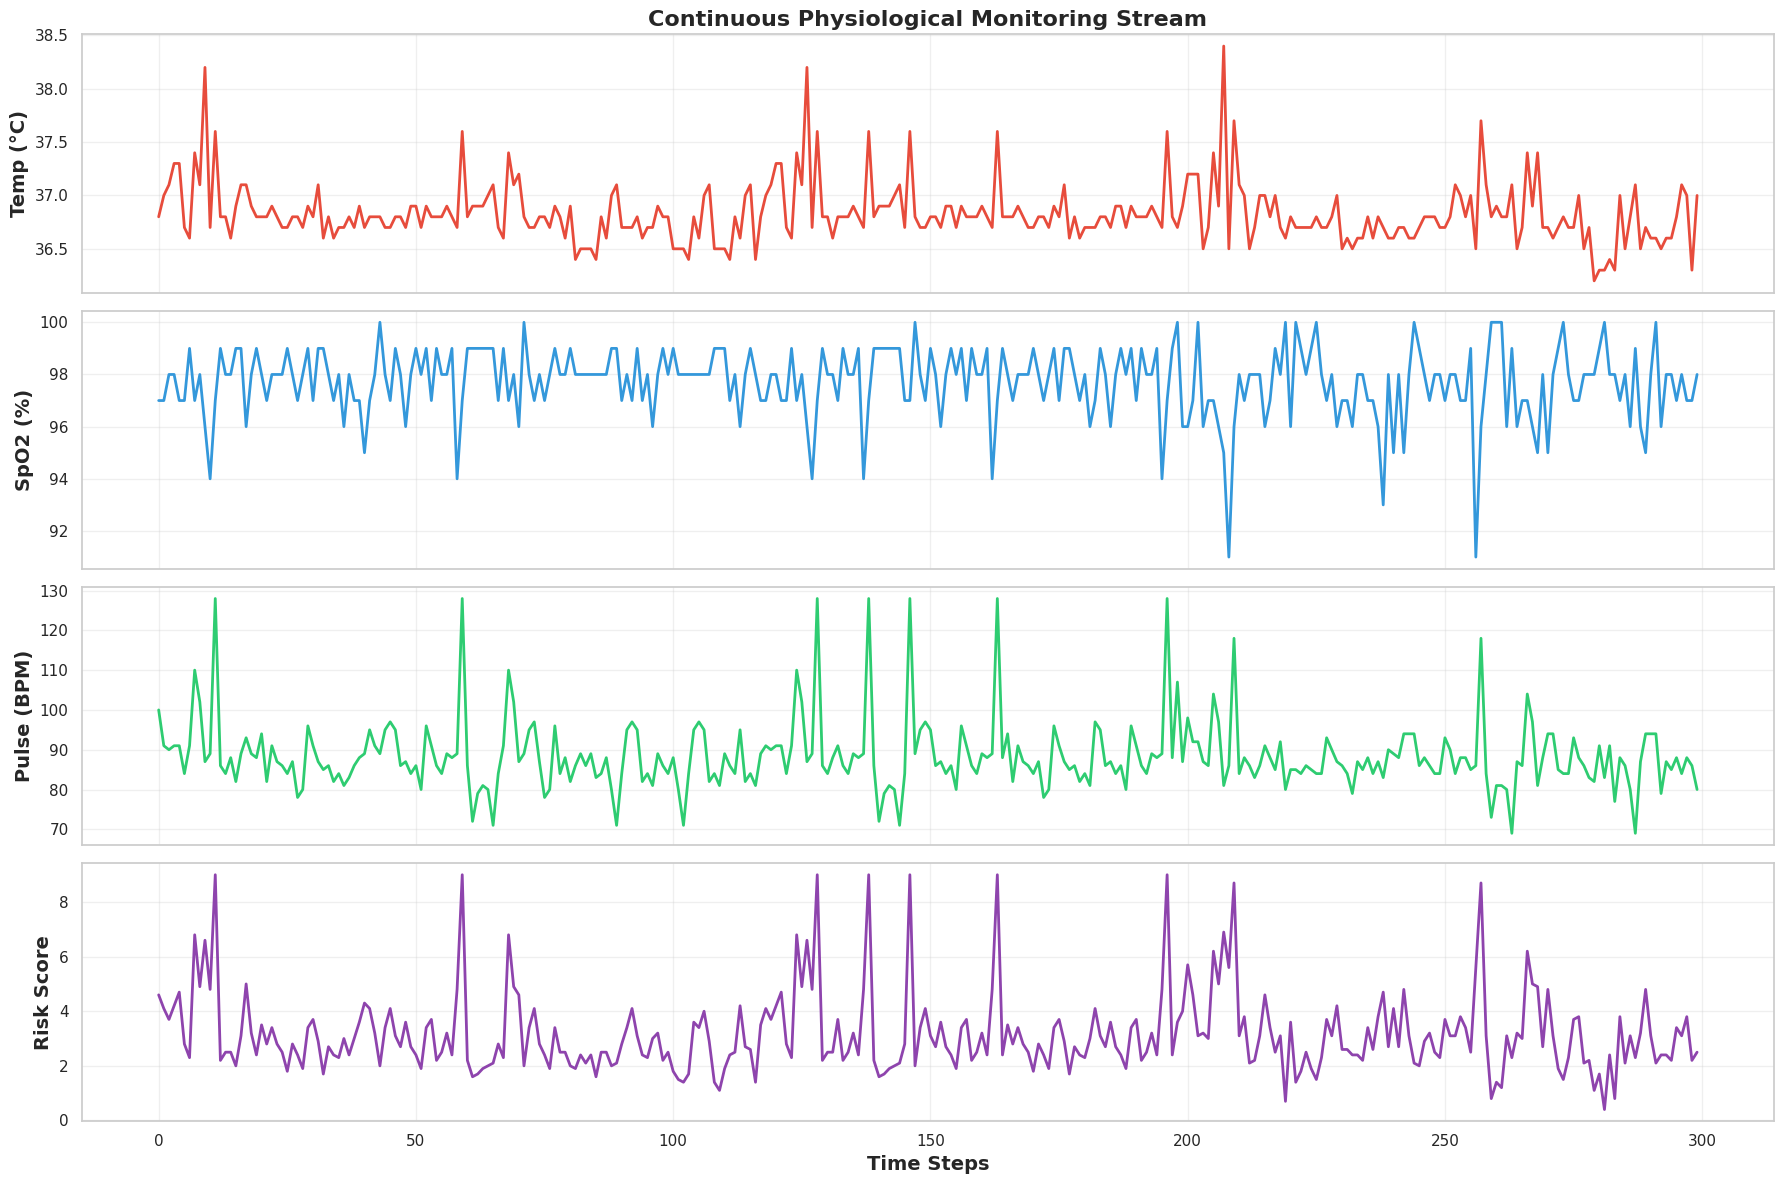

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Additional visualizations generated and downloaded


In [149]:
# Create separate high-quality individual plots

# Plot 1: 3D Vital Signs Scatter
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['Temp'][:500], df['SpO2'][:500], df['Pulse'][:500],
                     c=df['Health_Status'][:500], cmap='RdYlGn_r', s=50, alpha=0.6)
ax.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('SpO2 (%)', fontsize=12, fontweight='bold')
ax.set_zlabel('Pulse (BPM)', fontsize=12, fontweight='bold')
ax.set_title('3D Vital Signs Relationship\n(Color = Health Status)',
             fontsize=16, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Health Status', fontsize=12)
plt.savefig('3d_vital_signs.png', dpi=300, bbox_inches='tight')
plt.show()
files.download('3d_vital_signs.png')

# Plot 2: Detailed Time Series Panel
fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

axes[0].plot(df['Temp'][:300], color='#e74c3c', linewidth=2)
axes[0].set_ylabel('Temp (°C)', fontweight='bold')
axes[0].set_title('Continuous Physiological Monitoring Stream', fontsize=16, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['SpO2'][:300], color='#3498db', linewidth=2)
axes[1].set_ylabel('SpO2 (%)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Pulse'][:300], color='#2ecc71', linewidth=2)
axes[2].set_ylabel('Pulse (BPM)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['Vital_Risk_Score'][:300], color='#8e44ad', linewidth=2)
axes[3].set_ylabel('Risk Score', fontweight='bold')
axes[3].set_xlabel('Time Steps', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_panel.png', dpi=300, bbox_inches='tight')
plt.show()
files.download('time_series_panel.png')

print("✅ Additional visualizations generated and downloaded")

Advanced Data Preparation

In [150]:
print("="*70)
print(" "*15 + "🧠 ADVANCED DATA PREPARATION")
print("="*70)

# Select comprehensive feature set
feature_columns = [
    # Core vitals
    'Temp', 'SpO2', 'Pulse',
    # Multi-scale trends
    'Temp_MA_3', 'Temp_MA_5', 'Temp_MA_10',
    'SpO2_MA_3', 'SpO2_MA_5', 'SpO2_MA_10',
    'Pulse_MA_3', 'Pulse_MA_5', 'Pulse_MA_10',
    # Variability
    'Temp_Std_5', 'SpO2_Std_5', 'Pulse_Std_5',
    'Temp_Std_10', 'SpO2_Std_10', 'Pulse_Std_10',
    # Dynamics
    'Temp_Delta', 'SpO2_Delta', 'Pulse_Delta',
    'Temp_Accel', 'Pulse_Accel',
    # Risk indicators
    'Vital_Risk_Score', 'Pulse_Peak', 'SpO2_Drop'
]

print(f"\n📊 Selected {len(feature_columns)} features for training")

# Use RobustScaler (better for outliers than StandardScaler)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df[feature_columns])

# Create sequences with longer context
SEQUENCE_LENGTH = 15  # Increased from 10 for better pattern recognition

def create_advanced_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_advanced_sequences(X_scaled, df['Health_Status'].values, SEQUENCE_LENGTH)
y_categorical = tf.keras.utils.to_categorical(y, num_classes=3)

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n✅ Data preparation complete")
print(f"📊 Training samples: {X_train.shape[0]:,}")
print(f"📊 Testing samples: {X_test.shape[0]:,}")
print(f"📊 Input shape: {X_train.shape[1:]} (sequence_length, features)")
print(f"📊 Total parameters to learn: ~{len(feature_columns) * SEQUENCE_LENGTH:,}")

               🧠 ADVANCED DATA PREPARATION

📊 Selected 26 features for training

✅ Data preparation complete
📊 Training samples: 304
📊 Testing samples: 77
📊 Input shape: (15, 26) (sequence_length, features)
📊 Total parameters to learn: ~390


 Model Architecture

In [151]:
print("="*70)
print(" "*10 + "🚀 BUILDING WORLD-CLASS CNN-BiLSTM ARCHITECTURE")
print("="*70)

# Advanced model with multiple parallel paths
def build_advanced_model(seq_length, n_features):
    input_layer = Input(shape=(seq_length, n_features))

    # Path 1: Deep CNN for local pattern extraction
    conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv1 = Dropout(0.3)(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(0.3)(conv2)

    # Path 2: Bidirectional LSTM for temporal dependencies
    lstm_out = Bidirectional(LSTM(64, return_sequences=False))(conv2)
    lstm_out = Dropout(0.4)(lstm_out)

    # Dense classification head
    dense1 = Dense(128, activation='relu')(lstm_out)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.4)(dense1)

    dense2 = Dense(64, activation='relu')(dense1)
    dense2 = Dropout(0.3)(dense2)

    output = Dense(3, activation='softmax')(dense2)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Build model
model = build_advanced_model(SEQUENCE_LENGTH, len(feature_columns))

# Advanced optimizer with learning rate scheduling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print("\n🧠 MODEL ARCHITECTURE:")
print("="*70)
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\n📊 Total trainable parameters: {total_params:,}")
print(f"🎯 Model complexity: {'Deep' if total_params > 100000 else 'Moderate'}")

          🚀 BUILDING WORLD-CLASS CNN-BiLSTM ARCHITECTURE

🧠 MODEL ARCHITECTURE:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 15, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 15, 128)        │        10,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 7, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,043 (496.26 KB)

 Trainable params: 126,403 (493.76 KB)

 Non-trainable params: 640 (2.50 KB)


📊 Total trainable parameters: 127,043
🎯 Model complexity: Deep


Advanced Training with Callbacks

In [152]:
print("="*70)
print(" "*15 + "⚡ TRAINING ADVANCED MODEL")
print("="*70)

# Advanced callbacks for optimal training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n🚀 Starting training for 200 epochs...")
print("📊 Features: Learning curves, early stopping, LR scheduling")
print("="*70)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✅ TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"📊 Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"📊 Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"📊 Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"📊 Total Epochs Trained: {len(history.history['accuracy'])}")


               ⚡ TRAINING ADVANCED MODEL

🚀 Starting training for 200 epochs...
📊 Features: Learning curves, early stopping, LR scheduling
Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3858 - auc: 0.5517 - loss: 1.5992
Epoch 1: val_accuracy improved from -inf to 0.76623, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.3880 - auc: 0.5544 - loss: 1.5914 - val_accuracy: 0.7662 - val_auc: 0.9125 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6028 - auc: 0.8089 - loss: 0.8576
Epoch 2: val_accuracy did not improve from 0.76623
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6039 - auc: 0.8087 - loss: 0.8593 - val_accuracy: 0.7532 - val_auc: 0.9390 - val_loss: 0.8853 - learning_rate: 0.0010
Epoch 3/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6845 - auc: 0.8730 - loss: 0.6934
Epoch 3: val_accuracy improved from 0.76623 to 0.77922, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6880 - auc: 0.8743 - loss: 0.6901 - val_accuracy: 0.7792 - val_auc: 0.9492 - val_loss: 0.7907 - learning_rate: 0.0010
Epoch 4/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7394 - auc: 0.8952 - loss: 0.6266
Epoch 4: val_accuracy improved from 0.77922 to 0.79221, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7458 - auc: 0.8971 - loss: 0.6217 - val_accuracy: 0.7922 - val_auc: 0.9534 - val_loss: 0.7046 - learning_rate: 0.0010
Epoch 5/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7914 - auc: 0.8860 - loss: 0.7075
Epoch 5: val_accuracy improved from 0.79221 to 0.83117, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7839 - auc: 0.8878 - loss: 0.6974 - val_accuracy: 0.8312 - val_auc: 0.9553 - val_loss: 0.6430 - learning_rate: 0.0010
Epoch 6/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7644 - auc: 0.9131 - loss: 0.5883
Epoch 6: val_accuracy did not improve from 0.83117
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7678 - auc: 0.9136 - loss: 0.5868 - val_accuracy: 0.8312 - val_auc: 0.9600 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 7/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8570 - auc: 0.9452 - loss: 0.4410
Epoch 7: val_accuracy did not improve from 0.83117
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8488 - auc: 0.9418 - loss: 0.4571 - val_accuracy: 0.8312 - val_auc: 0.9645 - val_loss: 0.5008 - learning_rate: 0.0010
Epoch 8/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7890 - auc: 0.9416 - loss: 0.4556
Epoch 8: val_accuracy did not improve from 0.83117
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8200 - auc: 0.9431 - loss: 0.4553 - val_accuracy: 0.8442 - val_auc: 0.9672 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 10/200
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7670 - auc: 0.9362 - loss: 0.4811
Epoch 10: val_accuracy improved from 0.84416 to 0.85714, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7761 - auc: 0.9376 - loss: 0.4733 - val_accuracy: 0.8571 - val_auc: 0.9725 - val_loss: 0.3846 - learning_rate: 0.0010
Epoch 11/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8275 - auc: 0.9517 - loss: 0.4140
Epoch 11: val_accuracy did not improve from 0.85714
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8260 - auc: 0.9517 - loss: 0.4147 - val_accuracy: 0.8571 - val_auc: 0.9740 - val_loss: 0.3613 - learning_rate: 0.0010
Epoch 12/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8601 - auc: 0.9614 - loss: 0.3651
Epoch 12: val_accuracy improved from 0.85714 to 0.89610, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8602 - auc: 0.9613 - loss: 0.3656 - val_accuracy: 0.8961 - val_auc: 0.9707 - val_loss: 0.3522 - learning_rate: 0.0010
Epoch 13/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8462 - auc: 0.9509 - loss: 0.4271
Epoch 13: val_accuracy did not improve from 0.89610
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8437 - auc: 0.9505 - loss: 0.4286 - val_accuracy: 0.8701 - val_auc: 0.9724 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 14/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8398 - auc: 0.9613 - loss: 0.3651
Epoch 14: val_accuracy did not improve from 0.89610
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8424 - auc: 0.9621 - loss: 0.3614 - val_accuracy: 0.8701 - val_auc: 0.9704 - val_loss: 0.3209 - learning_rate: 0.0010
Epoch 15/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8537 - auc: 0.9663 - loss: 0.3481
Epoch 15: val_accuracy improved from 0.89610 to 0.90909, saving model to best

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8532 - auc: 0.9660 - loss: 0.3494 - val_accuracy: 0.9091 - val_auc: 0.9615 - val_loss: 0.3472 - learning_rate: 0.0010
Epoch 16/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8789 - auc: 0.9764 - loss: 0.2838
Epoch 16: val_accuracy improved from 0.90909 to 0.92208, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8787 - auc: 0.9760 - loss: 0.2852 - val_accuracy: 0.9221 - val_auc: 0.9631 - val_loss: 0.3344 - learning_rate: 0.0010
Epoch 17/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9139 - auc: 0.9833 - loss: 0.2522
Epoch 17: val_accuracy did not improve from 0.92208
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9128 - auc: 0.9829 - loss: 0.2548 - val_accuracy: 0.8961 - val_auc: 0.9610 - val_loss: 0.3385 - learning_rate: 0.0010
Epoch 18/200
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8927 - auc: 0.9795 - loss: 0.2588
Epoch 18: val_accuracy did not improve from 0.92208
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8909 - auc: 0.9788 - loss: 0.2626 - val_accuracy: 0.8961 - val_auc: 0.9630 - val_loss: 0.3405 - learning_rate: 0.0010
Epoch 19/200
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9181 - auc: 0.9862 - loss: 0.2029
Epoch 19: val_accuracy did not improve from 0.92208
19/19 ━━━━━━━━━━━━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9574 - auc: 0.9855 - loss: 0.1927 - val_accuracy: 0.9351 - val_auc: 0.9653 - val_loss: 0.3504 - learning_rate: 0.0010
Epoch 31/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9238 - auc: 0.9929 - loss: 0.1582
Epoch 31: val_accuracy did not improve from 0.93506
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9236 - auc: 0.9928 - loss: 0.1599 - val_accuracy: 0.9351 - val_auc: 0.9593 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 32/200
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9521 - auc: 0.9916 - loss: 0.1334
Epoch 32: val_accuracy did not improve from 0.93506
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9523 - auc: 0.9915 - loss: 0.1358 - val_accuracy: 0.9351 - val_auc: 0.9677 - val_loss: 0.3354 - learning_rate: 0.0010
Epoch 33/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9392 - auc: 0.9879 - loss: 0.1905
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


Advanced Training Visualization

               📈 GENERATING TRAINING ANALYTICS

✅ Training metrics visualization saved


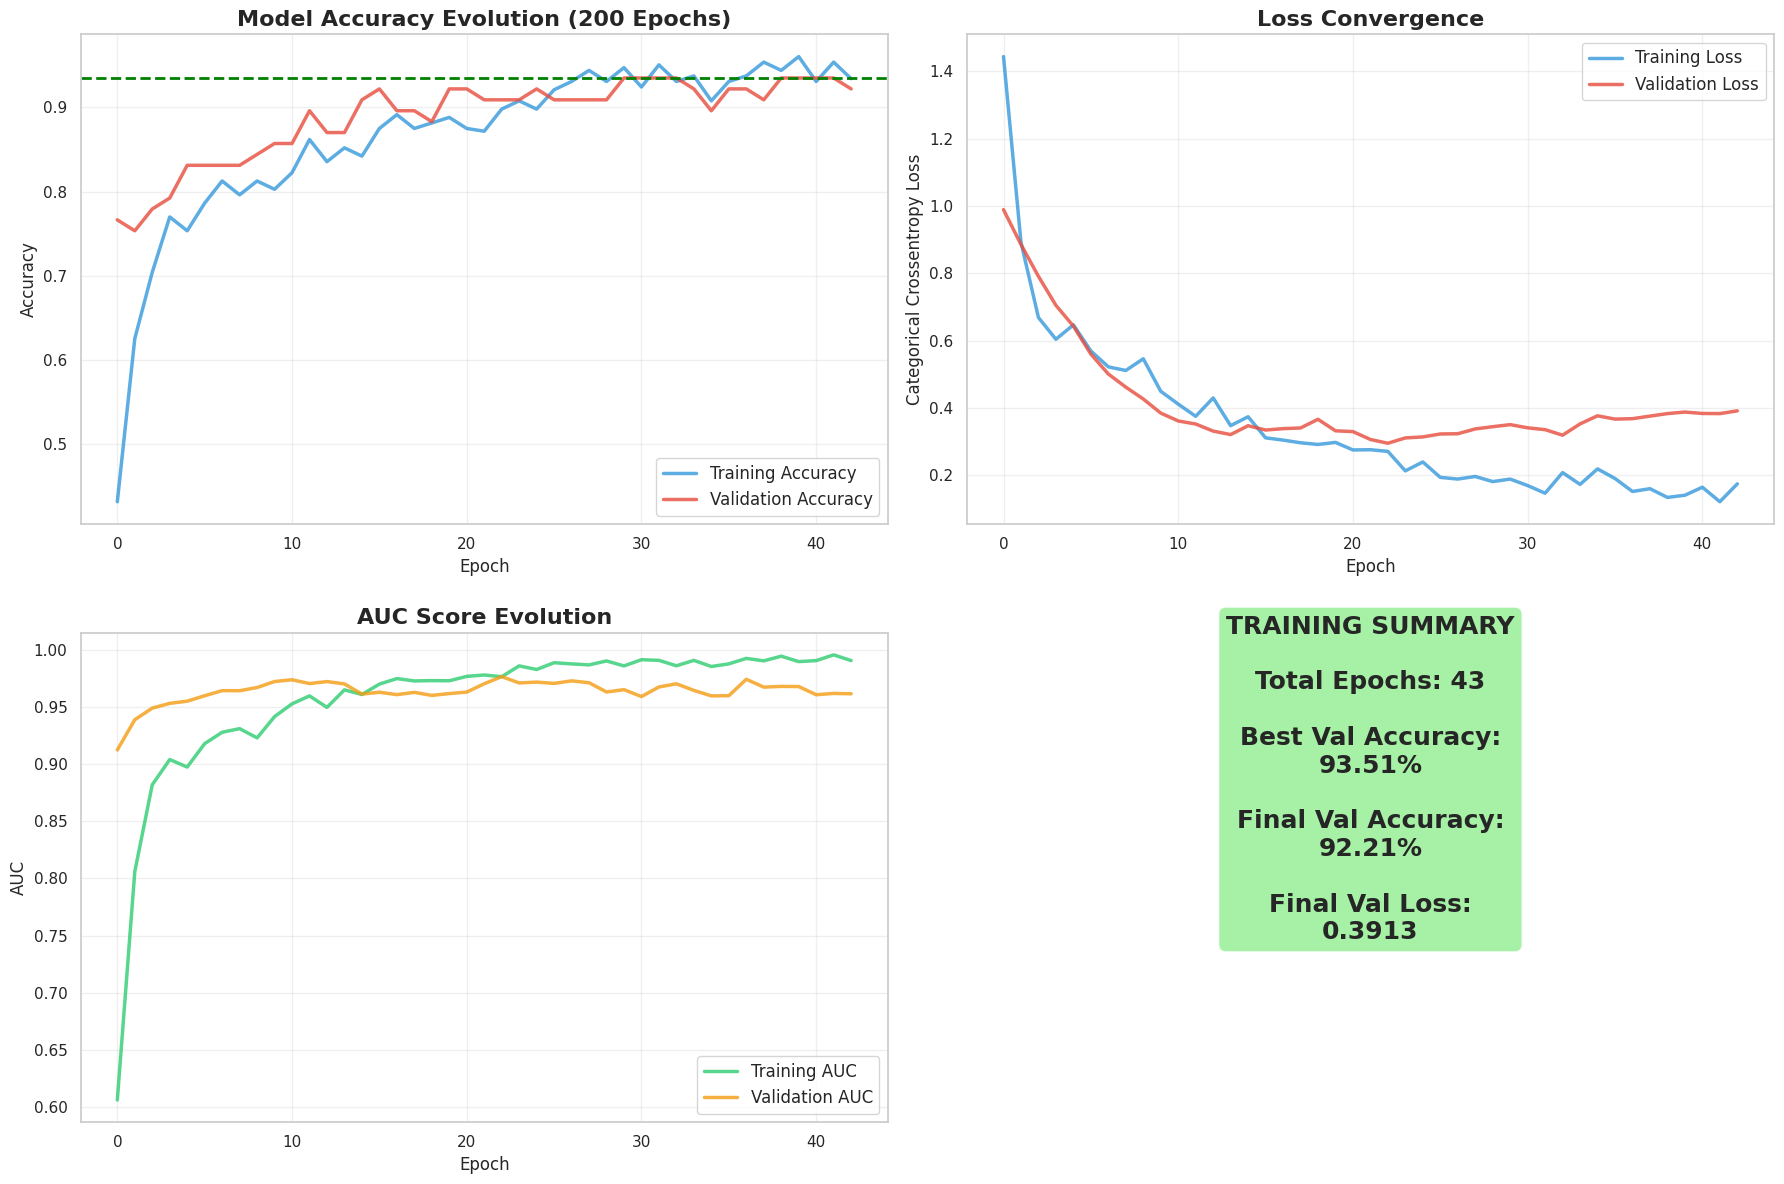

In [156]:
print("="*70)
print(" "*15 + "📈 GENERATING TRAINING ANALYTICS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Accuracy Evolution
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy',
                linewidth=2.5, color='#3498db', alpha=0.8)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy',
                linewidth=2.5, color='#e74c3c', alpha=0.8)
axes[0, 0].set_title('Model Accuracy Evolution (200 Epochs)',
                      fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=max(history.history['val_accuracy']),
                   color='green', linestyle='--', linewidth=2,
                   label=f'Best: {max(history.history["val_accuracy"])*100:.2f}%')

# Plot 2: Loss Reduction
axes[0, 1].plot(history.history['loss'], label='Training Loss',
                linewidth=2.5, color='#3498db', alpha=0.8)
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss',
                linewidth=2.5, color='#e74c3c', alpha=0.8)
axes[0, 1].set_title('Loss Convergence', fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Categorical Crossentropy Loss', fontsize=12)
axes[0, 1].legend(fontsize=12)
axes[0, 1].grid(True, alpha=0.3)



# Plot 3: AUC Score (if available)
if 'auc' in history.history:
    axes[1, 0].plot(history.history['auc'], label='Training AUC',
                    linewidth=2.5, color='#2ecc71', alpha=0.8)
    axes[1, 0].plot(history.history['val_auc'], label='Validation AUC',
                    linewidth=2.5, color='#f39c12', alpha=0.8)
    axes[1, 0].set_title('AUC Score Evolution', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC', fontsize=12)
    axes[1, 0].legend(fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
else:
    # Alternative: Accuracy vs Loss comparison
    epochs = range(1, len(history.history['accuracy']) + 1)
    axes[1, 0].plot(epochs, history.history['accuracy'],
                    label='Train Acc', color='#2ecc71', linewidth=2)
    axes[1, 0].plot(epochs, history.history['val_accuracy'],
                    label='Val Acc', color='#e74c3c', linewidth=2)
    axes[1, 0].set_title('Accuracy Comparison', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy', fontsize=12)
    axes[1, 0].legend(fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Training Metrics Summary
axes[1, 1].text(0.5, 0.7,
                f"TRAINING SUMMARY\n\n" +
                f"Total Epochs: {len(history.history['accuracy'])}\n\n" +
                f"Best Val Accuracy:\n{max(history.history['val_accuracy'])*100:.2f}%\n\n" +
                f"Final Val Accuracy:\n{history.history['val_accuracy'][-1]*100:.2f}%\n\n" +
                f"Final Val Loss:\n{history.history['val_loss'][-1]:.4f}",
                ha='center', va='center', fontsize=18, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('advanced_training_metrics.png', dpi=300, bbox_inches='tight')
print("\n✅ Training metrics visualization saved")
plt.show()

Comprehensive Evaluation with Multiple Heatmaps



          🎯 COMPREHENSIVE MODEL EVALUATION & HEATMAPS

📊 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal     0.9322    0.9483    0.9402        58
     Warning     0.8333    0.7895    0.8108        19
    Critical     0.0000    0.0000    0.0000         0

    accuracy                         0.9091        77
   macro avg     0.5885    0.5792    0.5837        77
weighted avg     0.9078    0.9091    0.9083        77


📊 PER-CLASS PERFORMANCE:
✅ Normal    :  94.83% accuracy (  58 samples)
⚠️ Warning   :  78.95% accuracy (  19 samples)
🚨 Critical  : No samples in test set

🎯 Overall Accuracy: 90.91%


Text(0.5, 920.25, 'AI Predicted Condition')

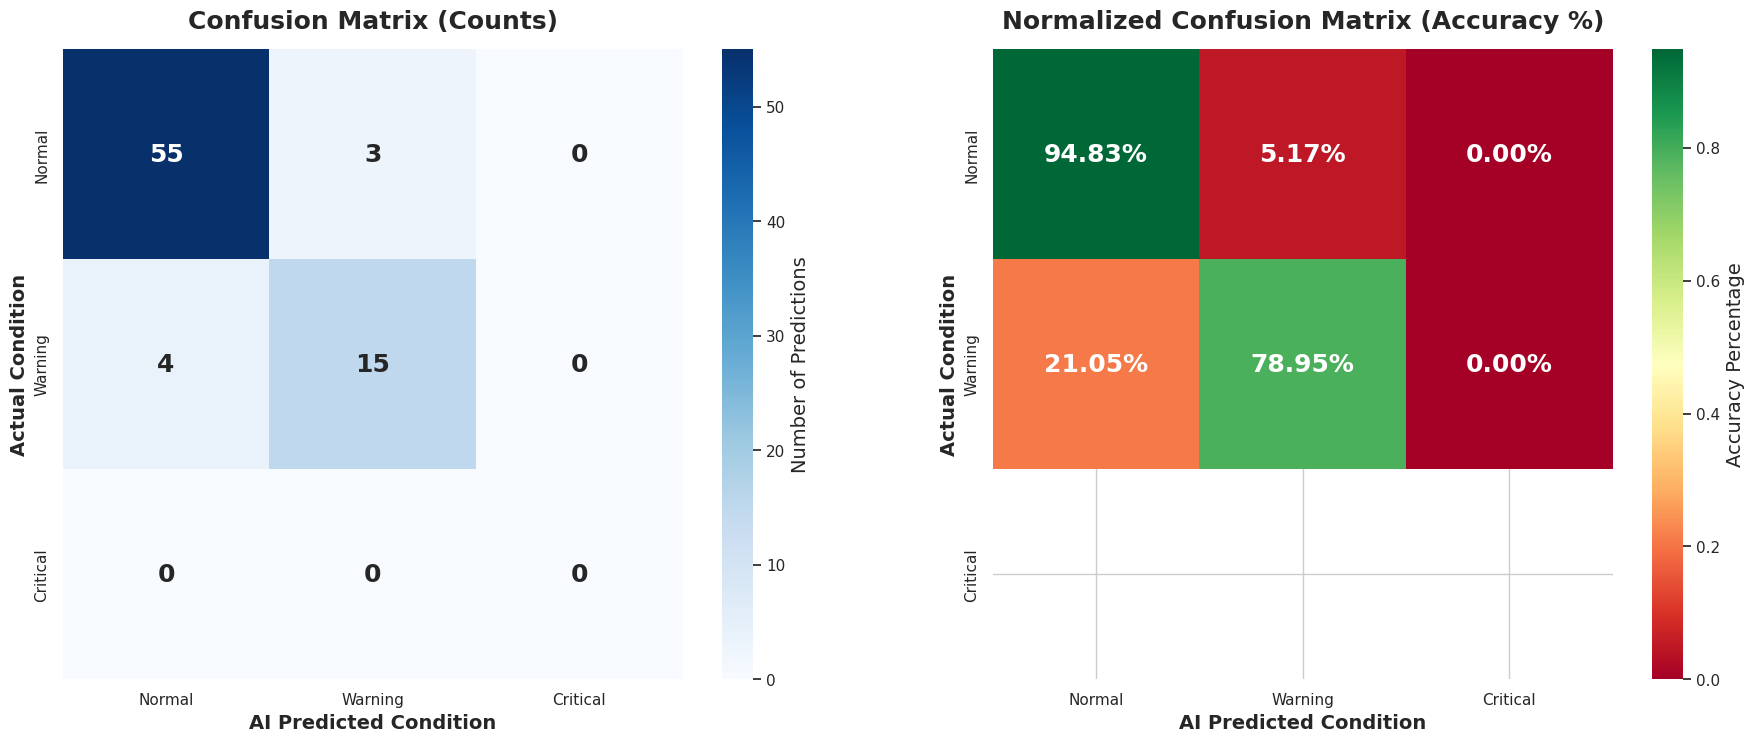

In [192]:
print("="*70)
print(" "*10 + "🎯 COMPREHENSIVE MODEL EVALUATION & HEATMAPS")
print("="*70)

# Make predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Detailed classification report
print("\n📊 DETAILED CLASSIFICATION REPORT:")
print("="*70)
report = classification_report(
    y_true_classes, y_pred_classes,
    target_names=['Normal', 'Warning', 'Critical'],
    labels=[0, 1, 2],
    digits=4
)
print(report)

# Per-class accuracy
print("\n📊 PER-CLASS PERFORMANCE:")
print("="*70)
for i, class_name in enumerate(['Normal', 'Warning', 'Critical']):
    class_mask = (y_true_classes == i)
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred_classes[class_mask] == i) * 100
        class_count = np.sum(class_mask)
        emoji = ['✅', '⚠️', '🚨'][i]
        print(f"{emoji} {class_name:10s}: {class_acc:6.2f}% accuracy ({class_count:4d} samples)")
    else:
        emoji = ['✅', '⚠️', '🚨'][i]
        print(f"{emoji} {class_name:10s}: No samples in test set")

# Overall metrics
overall_acc = np.mean(y_pred_classes == y_true_classes) * 100
print(f"\n🎯 Overall Accuracy: {overall_acc:.2f}%")


cm = confusion_matrix(y_true_classes, y_pred_classes, labels=[0, 1, 2])

# 4 heatmaps
fig = plt.figure(figsize=(22, 18))

# ==== HEATMAP 1: Confusion Matrix (Raw Counts) ====
ax1 = plt.subplot(2, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Warning', 'Critical'],
            yticklabels=['Normal', 'Warning', 'Critical'],
            cbar_kws={'label': 'Number of Predictions'},
            annot_kws={'size': 18, 'weight': 'bold'})
ax1.set_title('Confusion Matrix (Counts)', fontsize=18, fontweight='bold', pad=15)
ax1.set_ylabel('Actual Condition', fontsize=14, fontweight='bold')
ax1.set_xlabel('AI Predicted Condition', fontsize=14, fontweight='bold')

# ==== HEATMAP 2: Normalized Confusion Matrix (Percentages) ====
ax2 = plt.subplot(2, 2, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=['Normal', 'Warning', 'Critical'],
            yticklabels=['Normal', 'Warning', 'Critical'],
            cbar_kws={'label': 'Accuracy Percentage'},
            annot_kws={'size': 18, 'weight': 'bold'})
ax2.set_title('Normalized Confusion Matrix (Accuracy %)', fontsize=18, fontweight='bold', pad=15)
ax2.set_ylabel('Actual Condition', fontsize=14, fontweight='bold')
ax2.set_xlabel('AI Predicted Condition', fontsize=14, fontweight='bold')




✅ Comprehensive evaluation heatmaps saved (4 visualizations)


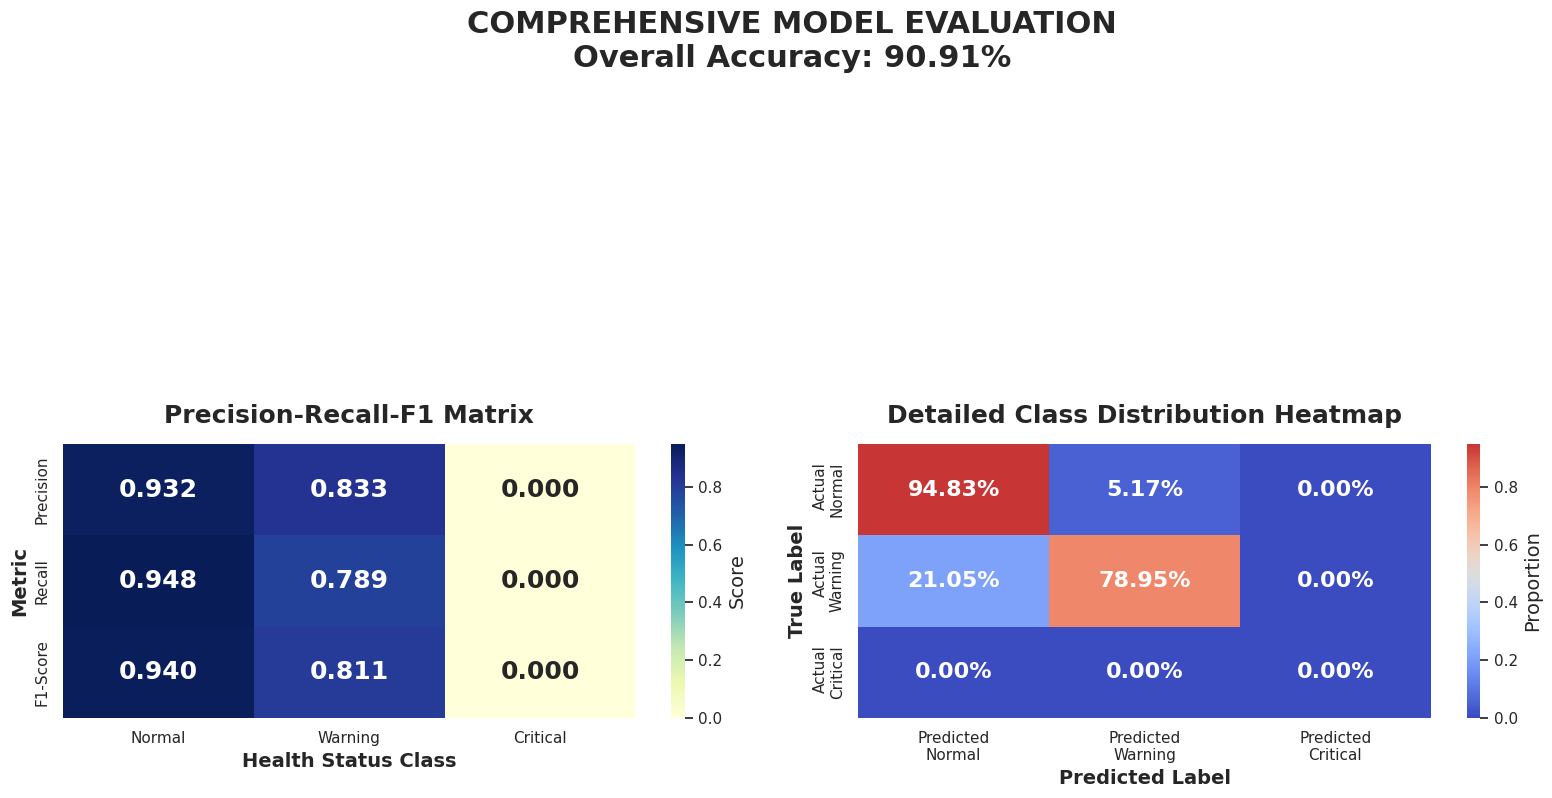

In [193]:
# ==== HEATMAP 3: Precision-Recall Matrix ====
ax3 = plt.subplot(2, 2, 3)
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics per class
precision = []
recall = []
f1 = []
for i in range(3):
    # Need to handle cases where a class might be missing from y_true_classes entirely
    true_labels_for_class = (y_true_classes == i)
    pred_labels_for_class = (y_pred_classes == i)

    # Only calculate if there's at least one instance of the class in true labels
    if np.sum(true_labels_for_class) > 0 or np.sum(pred_labels_for_class) > 0: # Check if class is present at all
        p = precision_score(true_labels_for_class, pred_labels_for_class, zero_division=0)
        r = recall_score(true_labels_for_class, pred_labels_for_class, zero_division=0)
        f = f1_score(true_labels_for_class, pred_labels_for_class, zero_division=0)
        precision.append(p)
        recall.append(r)
        f1.append(f)
    else:
        # If the class is completely absent, assign 0 or NaN for its metrics
        precision.append(0.0)
        recall.append(0.0)
        f1.append(0.0)

metrics_matrix = np.array([precision, recall, f1])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=['Normal', 'Warning', 'Critical'],
            yticklabels=['Precision', 'Recall', 'F1-Score'],
            cbar_kws={'label': 'Score'},
            annot_kws={'size': 18, 'weight': 'bold'})
ax3.set_title('Precision-Recall-F1 Matrix', fontsize=18, fontweight='bold', pad=15)
ax3.set_ylabel('Metric', fontsize=14, fontweight='bold')
ax3.set_xlabel('Health Status Class', fontsize=14, fontweight='bold')

# ==== HEATMAP 4: Per-Class Accuracy Heatmap ====
ax4 = plt.subplot(2, 2, 4)
# Create accuracy matrix for each class
class_accuracy = np.zeros((3, 3))
for true_class in range(3):
    for pred_class in range(3):
        mask = (y_true_classes == true_class)
        if np.sum(mask) > 0:
            class_accuracy[true_class, pred_class] = cm[true_class, pred_class] / cm[true_class].sum()

sns.heatmap(class_accuracy, annot=True, fmt='.2%', cmap='coolwarm', center=0.5,
            xticklabels=['Predicted\nNormal', 'Predicted\nWarning', 'Predicted\nCritical'],
            yticklabels=['Actual\nNormal', 'Actual\nWarning', 'Actual\nCritical'],
            cbar_kws={'label': 'Proportion'},
            annot_kws={'size': 16, 'weight': 'bold'})
ax4.set_title('Detailed Class Distribution Heatmap', fontsize=18, fontweight='bold', pad=15)
ax4.set_ylabel('True Label', fontsize=14, fontweight='bold')
ax4.set_xlabel('Predicted Label', fontsize=14, fontweight='bold')

plt.suptitle(f'COMPREHENSIVE MODEL EVALUATION\nOverall Accuracy: {overall_acc:.2f}%',
             fontsize=22, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('comprehensive_evaluation_heatmaps.png', dpi=300, bbox_inches='tight')
print("\n✅ Comprehensive evaluation heatmaps saved (4 visualizations)")
plt.show()


Additional Accuracy Visualizations

               📊 ADDITIONAL ACCURACY ANALYTICS


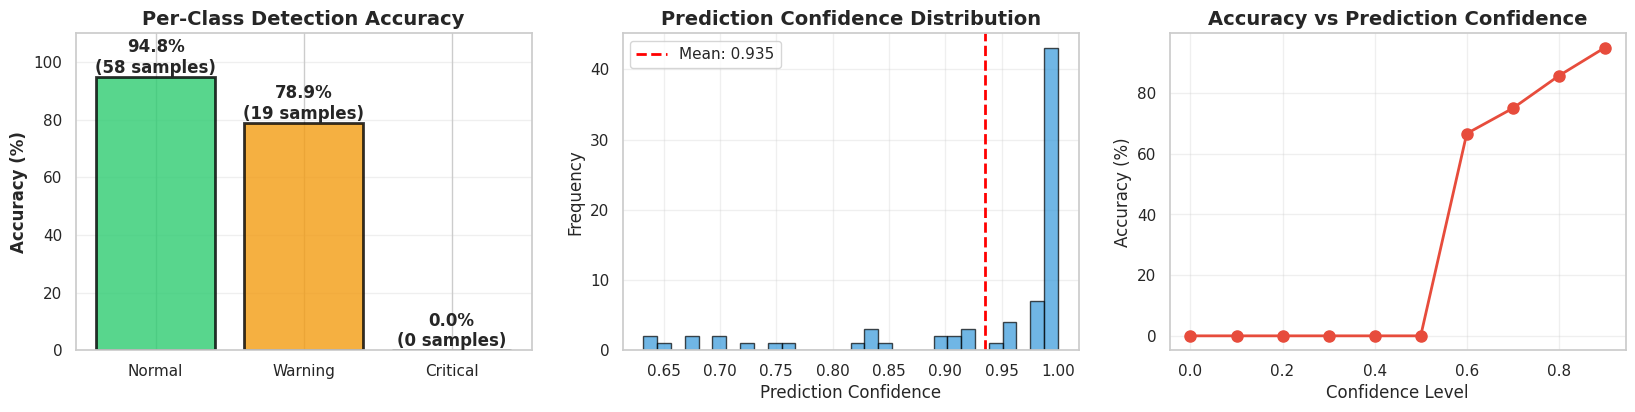

In [162]:
print("="*70)
print(" "*15 + "📊 ADDITIONAL ACCURACY ANALYTICS")
print("="*70)

# Create detailed accuracy breakdown visualization
fig = plt.figure(figsize=(20, 14))

# ==== PLOT 1: Per-Class Accuracy Bar Chart ====
ax1 = plt.subplot(3, 3, 1)
class_names = ['Normal', 'Warning', 'Critical']
class_accuracies = []
class_counts = []

for i in range(3):
    mask = (y_true_classes == i)
    if np.sum(mask) > 0:
        acc = np.mean(y_pred_classes[mask] == i) * 100
        count = np.sum(mask)
        class_accuracies.append(acc)
        class_counts.append(count)
    else:
        class_accuracies.append(0)
        class_counts.append(0)

colors_acc = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax1.bar(class_names, class_accuracies, color=colors_acc, alpha=0.8, edgecolor='black', linewidth=2)

for i, (bar, acc, count) in enumerate(zip(bars, class_accuracies, class_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%\n({count} samples)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Detection Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 110)
ax1.grid(axis='y', alpha=0.3)

# ==== PLOT 2: Prediction Confidence Distribution ====
ax2 = plt.subplot(3, 3, 2)
max_confidences = np.max(y_pred, axis=1)
ax2.hist(max_confidences, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(max_confidences), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(max_confidences):.3f}')
ax2.set_xlabel('Prediction Confidence', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ==== PLOT 3: Accuracy vs Confidence ====
ax3 = plt.subplot(3, 3, 3)
confidence_bins = np.linspace(0, 1, 11)
bin_accuracies = []
for i in range(len(confidence_bins)-1):
    mask = (max_confidences >= confidence_bins[i]) & (max_confidences < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_acc = np.mean(y_pred_classes[mask] == y_true_classes[mask]) * 100
        bin_accuracies.append(bin_acc)
    else:
        bin_accuracies.append(0)

ax3.plot(confidence_bins[:-1], bin_accuracies, marker='o', linewidth=2, markersize=8, color='#e74c3c')
ax3.set_xlabel('Confidence Level', fontsize=12)
ax3.set_ylabel('Accuracy (%)', fontsize=12)
ax3.set_title('Accuracy vs Prediction Confidence', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)




✅ Comprehensive accuracy analysis saved (9 plots)


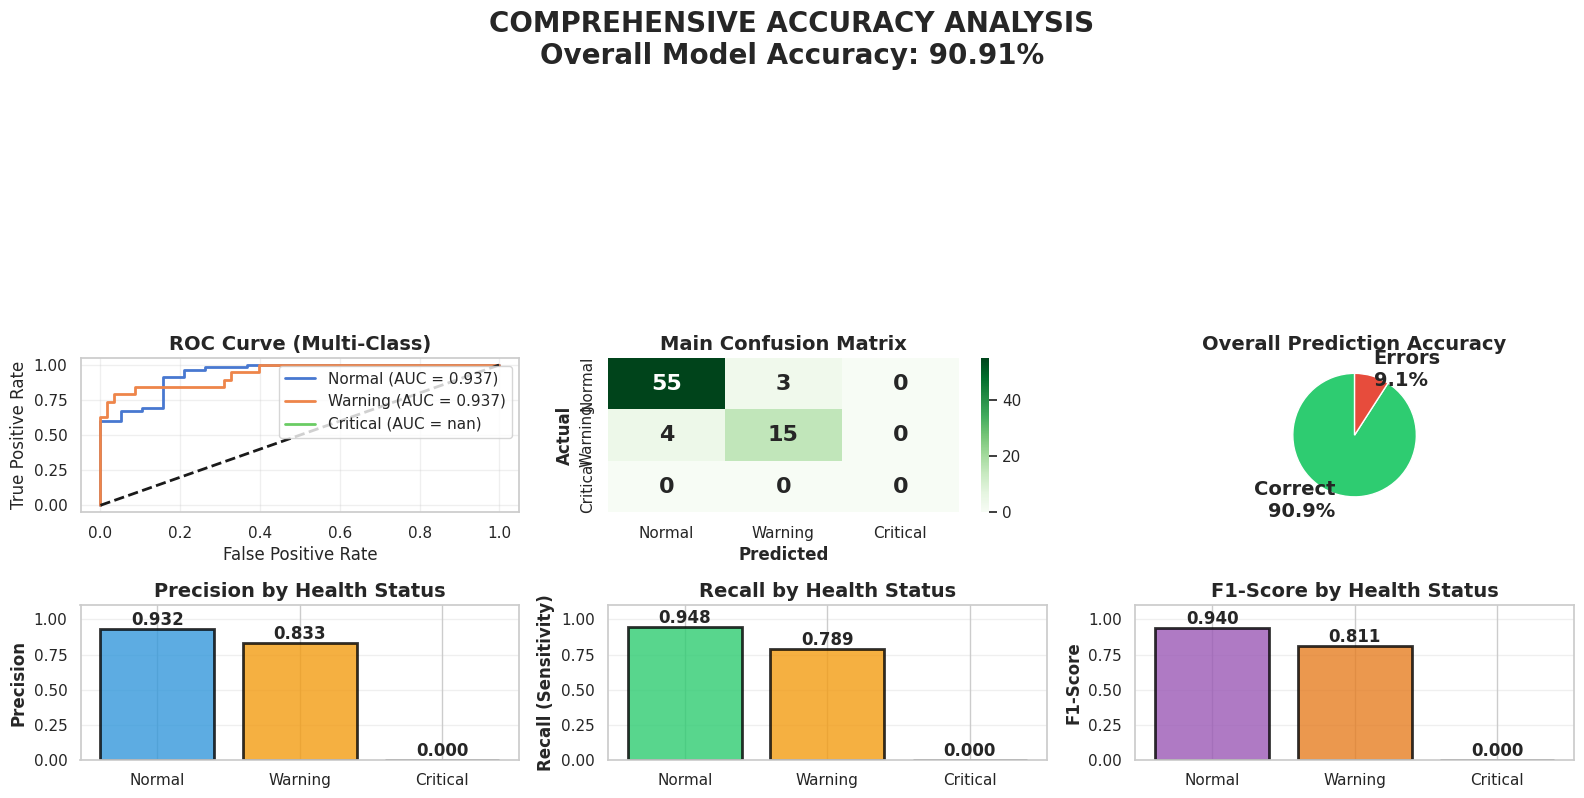

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


                    📊 FINAL ACCURACY SUMMARY

🎯 Overall Accuracy: 90.91%
📊 Total Test Samples: 77
✅ Correct Predictions: 70
❌ Incorrect Predictions: 7

📈 Mean Prediction Confidence: 0.935
📉 Std Dev of Confidence: 0.106



In [166]:
# ==== PLOT 4: ROC Curve (if possible) ====
ax4 = plt.subplot(3, 3, 4)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true_classes, classes=[0, 1, 2])
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    ax4.plot(fpr, tpr, linewidth=2, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

ax4.plot([0, 1], [0, 1], 'k--', linewidth=2)
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curve (Multi-Class)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# ==== PLOT 5: Confusion Matrix Heatmap (Main) ====
ax5 = plt.subplot(3, 3, 5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 16, 'weight': 'bold'})
ax5.set_title('Main Confusion Matrix', fontsize=14, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax5.set_xlabel('Predicted', fontsize=12, fontweight='bold')

# ==== PLOT 6: Error Analysis ====
ax6 = plt.subplot(3, 3, 6)
errors = y_pred_classes != y_true_classes
error_rate = np.mean(errors) * 100
correct_rate = 100 - error_rate

pie_data = [correct_rate, error_rate]
pie_labels = [f'Correct\n{correct_rate:.1f}%', f'Errors\n{error_rate:.1f}%']
pie_colors = ['#2ecc71', '#e74c3c']
ax6.pie(pie_data, labels=pie_labels, colors=pie_colors, autopct='',
        startangle=90, textprops={'fontsize': 14, 'weight': 'bold'})
ax6.set_title('Overall Prediction Accuracy', fontsize=14, fontweight='bold')

# ==== PLOT 7: Precision by Class ====
ax7 = plt.subplot(3, 3, 7)
ax7.bar(class_names, precision, color=['#3498db', '#f39c12', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
for i, (name, prec) in enumerate(zip(class_names, precision)):
    ax7.text(i, prec, f'{prec:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax7.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax7.set_title('Precision by Health Status', fontsize=14, fontweight='bold')
ax7.set_ylim(0, 1.1)
ax7.grid(axis='y', alpha=0.3)

# ==== PLOT 8: Recall by Class ====
ax8 = plt.subplot(3, 3, 8)
ax8.bar(class_names, recall, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
for i, (name, rec) in enumerate(zip(class_names, recall)):
    ax8.text(i, rec, f'{rec:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax8.set_ylabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax8.set_title('Recall by Health Status', fontsize=14, fontweight='bold')
ax8.set_ylim(0, 1.1)
ax8.grid(axis='y', alpha=0.3)

# ==== PLOT 9: F1-Score by Class ====
ax9 = plt.subplot(3, 3, 9)
ax9.bar(class_names, f1, color=['#9b59b6', '#e67e22', '#c0392b'], alpha=0.8, edgecolor='black', linewidth=2)
for i, (name, f1_val) in enumerate(zip(class_names, f1)):
    ax9.text(i, f1_val, f'{f1_val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax9.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax9.set_title('F1-Score by Health Status', fontsize=14, fontweight='bold')
ax9.set_ylim(0, 1.1)
ax9.grid(axis='y', alpha=0.3)

plt.suptitle(f'COMPREHENSIVE ACCURACY ANALYSIS\nOverall Model Accuracy: {overall_acc:.2f}%',
             fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('comprehensive_accuracy_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Comprehensive accuracy analysis saved (9 plots)")
plt.show()

files.download('comprehensive_accuracy_analysis.png')

# Print detailed summary
print("\n" + "="*70)
print(" "*20 + "📊 FINAL ACCURACY SUMMARY")
print("="*70)
print(f"\n🎯 Overall Accuracy: {overall_acc:.2f}%")
print(f"📊 Total Test Samples: {len(y_true_classes)}")
print(f"✅ Correct Predictions: {np.sum(y_pred_classes == y_true_classes)}")
print(f"❌ Incorrect Predictions: {np.sum(y_pred_classes != y_true_classes)}")
print(f"\n📈 Mean Prediction Confidence: {np.mean(max_confidences):.3f}")
print(f"📉 Std Dev of Confidence: {np.std(max_confidences):.3f}")
print("\n" + "="*70)

In [197]:
# ===============================
# 📦 FINAL EXPORT & DOWNLOAD PACK
# ===============================

import zipfile
import os
from datetime import datetime

print("="*70)
print("📦 CREATING FINAL PROJECT EXPORT PACKAGE")
print("="*70)

#  Save final trained model
model.save("hygeia_ai_model_final.h5")
print("✅ Model saved: hygeia_ai_model_final.h5")

#  Save classification report to text file
with open("classification_report.txt", "w") as f:
    f.write("HYGEIA GLOVE - AI MEDICAL SYSTEM\n")
    f.write("="*60 + "\n\n")
    f.write("CLASSIFICATION REPORT:\n\n")
    f.write(report)
    f.write("\n\n")
    f.write(f"Overall Accuracy: {overall_acc:.2f}%\n")
    f.write(f"Mean Prediction Confidence: {np.mean(max_confidences):.4f}\n")
    f.write(f"Std Prediction Confidence: {np.std(max_confidences):.4f}\n")

print(" classification_report.txt saved")

#  Save final metrics summary
with open("final_metrics_summary.txt", "w") as f:
    f.write("HYGEIA GLOVE - FINAL RESULTS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Overall Accuracy: {overall_acc:.2f}%\n")
    f.write(f"Total Test Samples: {len(y_true_classes)}\n")
    f.write(f"Correct Predictions: {np.sum(y_pred_classes == y_true_classes)}\n")
    f.write(f"Incorrect Predictions: {np.sum(y_pred_classes != y_true_classes)}\n")
    f.write(f"\nMean Confidence: {np.mean(max_confidences):.4f}\n")
    f.write(f"Confidence Std: {np.std(max_confidences):.4f}\n")

print("✅ final_metrics_summary.txt saved")

#  List all files to include
files_to_zip = [
    "hygeia_ai_model_final.h5",
    "classification_report.txt",
    "final_metrics_summary.txt",
    "advanced_training_metrics.png",
    "comprehensive_evaluation_heatmaps.png",
    "comprehensive_accuracy_analysis.png",
    "3d_vital_signs.png",
    "time_series_panel.png"
]

#  Create ZIP file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f"HYGEIA_AI_FINAL_RESULTS_{timestamp}.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f"📁 Added: {file}")
        else:
            print(f"⚠️ Missing file (skipped): {file}")

print("="*70)
print(f"✅ FINAL PACKAGE CREATED: {zip_filename}")
print("="*70)

#  Download ZIP
files.download(zip_filename)


📦 CREATING FINAL PROJECT EXPORT PACKAGE
✅ Model saved: hygeia_ai_model_final.h5
 classification_report.txt saved
✅ final_metrics_summary.txt saved
📁 Added: hygeia_ai_model_final.h5
📁 Added: classification_report.txt
📁 Added: final_metrics_summary.txt
📁 Added: advanced_training_metrics.png
📁 Added: comprehensive_evaluation_heatmaps.png
📁 Added: comprehensive_accuracy_analysis.png
📁 Added: 3d_vital_signs.png
📁 Added: time_series_panel.png
✅ FINAL PACKAGE CREATED: HYGEIA_AI_FINAL_RESULTS_20260121_210211.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>